In [1]:
# %%
import numpy as np
import pandas as pd
import os

# need to change data path in order to run locally
data_path = "/WAVE/users2/unix/rguan/cs240/240-project/Knee_Osteoarthritis_Classification"

categories = ["Normal", "Osteopenia", "Osteoporosis"]

image_paths = []
labels = []

for category in categories:
    category_path = os.path.join(data_path, "train", category)
    for image_name in os.listdir(category_path):
        image_path = os.path.join(category_path, image_name)
        image_paths.append(image_path)
        labels.append(category)


# %%
df = pd.DataFrame({"image_path": image_paths, "label": labels})
print(df.shape)


# %%
print(df.duplicated().sum())
print(df.isnull().sum())
print(df.info())
print("Unique labels: {}".format(df["label"].unique()))
print("Label counts: {}".format(df["label"].value_counts()))

# %%

(3780, 2)
0
image_path    0
label         0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3780 entries, 0 to 3779
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image_path  3780 non-null   object
 1   label       3780 non-null   object
dtypes: object(2)
memory usage: 59.2+ KB
None
Unique labels: ['Normal' 'Osteopenia' 'Osteoporosis']
Label counts: label
Normal          1260
Osteopenia      1260
Osteoporosis    1260
Name: count, dtype: int64


/tmp/ipykernel_2309952/2366761382.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x="label", palette="viridis", ax=ax)


Text(0.5, 1.0, 'Distribution of Tumor Types - Pie Chart')

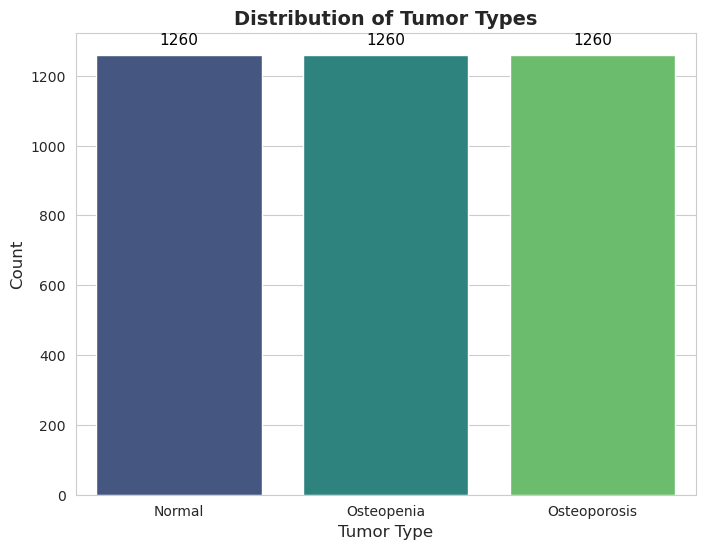

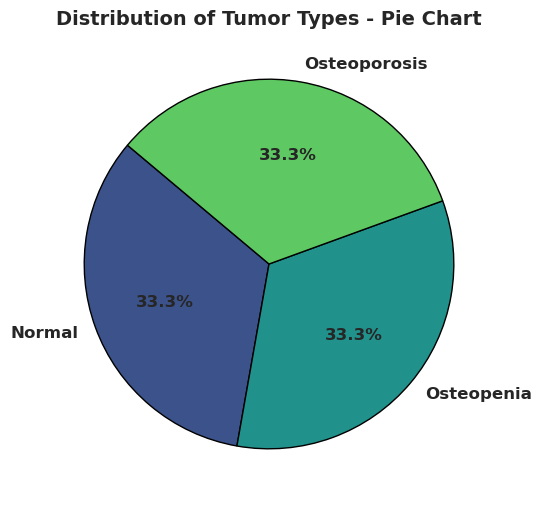

In [2]:

import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style("whitegrid")

fig, ax = plt.subplots(figsize=(8, 6))
sns.countplot(data=df, x="label", palette="viridis", ax=ax)
ax.set_title("Distribution of Tumor Types", fontsize=14, fontweight="bold")
ax.set_xlabel("Tumor Type", fontsize=12)
ax.set_ylabel("Count", fontsize=12)
for p in ax.patches:
    ax.annotate(
        f"{int(p.get_height())}",
        (p.get_x() + p.get_width() / 2.0, p.get_height()),
        ha="center",
        va="bottom",
        fontsize=11,
        color="black",
        xytext=(0, 5),
        textcoords="offset points",
    )
# plt.show()

# %%
label_counts = df["label"].value_counts()
fig, ax = plt.subplots(figsize=(8, 6))
colors = sns.color_palette("viridis", len(label_counts))
ax.pie(
    label_counts,
    labels=label_counts.index,
    autopct="%1.1f%%",
    startangle=140,
    colors=colors,
    textprops={"fontsize": 12, "weight": "bold"},
    wedgeprops={"edgecolor": "black", "linewidth": 1},
)
ax.set_title("Distribution of Tumor Types - Pie Chart", fontsize=14, fontweight="bold")
# plt.show()

# %%

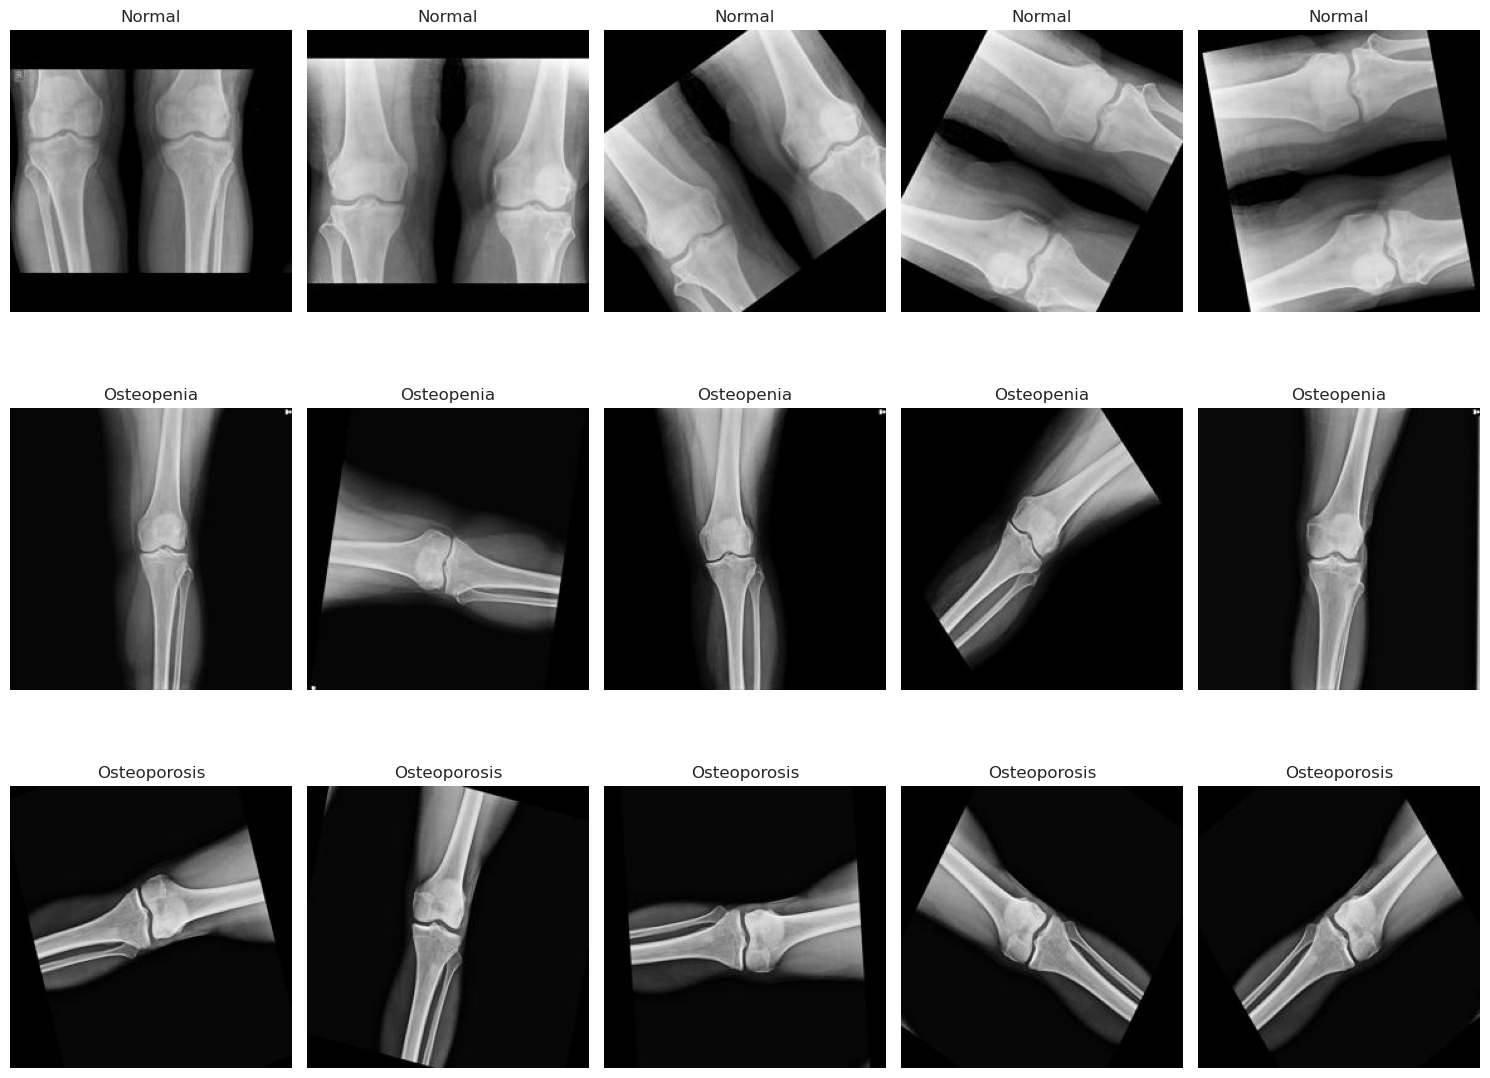

In [3]:
import cv2

num_images = 5
plt.figure(figsize=(15, 12))
for i, category in enumerate(categories):
    category_images = df[df["label"] == category]["image_path"].iloc[:num_images]
    for j, img_path in enumerate(category_images):
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.subplot(len(categories), num_images, i * num_images + j + 1)
        plt.imshow(img)
        plt.axis("off")
        plt.title(category)

plt.tight_layout()
plt.show(block=False)
plt.pause(5)
plt.close()

# %%

In [4]:

from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
df["category_encoded"] = label_encoder.fit_transform(df["label"])
df = df[["image_path", "category_encoded"]]


In [5]:


# %%
from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler(random_state=42)
X_resampled, y_resampled = ros.fit_resample(df[["image_path"]], df["category_encoded"])
df_resampled = pd.DataFrame(X_resampled, columns=["image_path"])
df_resampled["category_encoded"] = y_resampled
print("\nClass distribution after oversampling:")
print(df_resampled["category_encoded"].value_counts())
print(df_resampled)

# %%
df_resampled["category_encoded"] = df_resampled["category_encoded"].astype(str)



Class distribution after oversampling:
category_encoded
0    1260
1    1260
2    1260
Name: count, dtype: int64
                                             image_path  category_encoded
0     /WAVE/users2/unix/rguan/cs240/240-project/Knee...                 0
1     /WAVE/users2/unix/rguan/cs240/240-project/Knee...                 0
2     /WAVE/users2/unix/rguan/cs240/240-project/Knee...                 0
3     /WAVE/users2/unix/rguan/cs240/240-project/Knee...                 0
4     /WAVE/users2/unix/rguan/cs240/240-project/Knee...                 0
...                                                 ...               ...
3775  /WAVE/users2/unix/rguan/cs240/240-project/Knee...                 2
3776  /WAVE/users2/unix/rguan/cs240/240-project/Knee...                 2
3777  /WAVE/users2/unix/rguan/cs240/240-project/Knee...                 2
3778  /WAVE/users2/unix/rguan/cs240/240-project/Knee...                 2
3779  /WAVE/users2/unix/rguan/cs240/240-project/Knee...                 2

In [1]:

# %%
import time
import shutil
import pathlib
import itertools
from PIL import Image
import cv2
import seaborn as sns

sns.set_style("darkgrid")
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import (
    Conv2D,
    MaxPooling2D,
    Flatten,
    Dense,
    Activation,
    Dropout,
    BatchNormalization,
)
from keras import regularizers
import warnings

warnings.filterwarnings("ignore")
print("check")

# %%
train_df_new, temp_df_new = train_test_split(
    df_resampled,
    train_size=0.8,
    shuffle=True,
    random_state=42,
    stratify=df_resampled["category_encoded"],
)
print(train_df_new.shape)
print(temp_df_new.shape)

# %%
valid_df_new, test_df_new = train_test_split(
    temp_df_new,
    test_size=0.5,
    shuffle=True,
    random_state=42,
    stratify=temp_df_new["category_encoded"],
)
print(valid_df_new.shape)
print(test_df_new.shape)

# %%
batch_size = 16
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)
tr_gen = ImageDataGenerator(rescale=1.0 / 255)
ts_gen = ImageDataGenerator(rescale=1.0 / 255)
train_gen_new = tr_gen.flow_from_dataframe(
    train_df_new,
    x_col="image_path",
    y_col="category_encoded",
    target_size=img_size,
    class_mode="sparse",
    color_mode="rgb",
    shuffle=True,
    batch_size=batch_size,
)

valid_gen_new = ts_gen.flow_from_dataframe(
    valid_df_new,
    x_col="image_path",
    y_col="category_encoded",
    target_size=img_size,
    class_mode="sparse",
    color_mode="rgb",
    shuffle=True,
    batch_size=batch_size,
)

test_gen_new = ts_gen.flow_from_dataframe(
    test_df_new,
    x_col="image_path",
    y_col="category_encoded",
    target_size=img_size,
    class_mode="sparse",
    color_mode="rgb",
    shuffle=False,
    batch_size=batch_size,
)

print("Num GPUs Available: ", len(tf.config.list_physical_devices("GPU")))

2025-02-24 22:09:58.857290: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-02-24 22:09:58.878102: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-02-24 22:09:58.884332: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-24 22:09:58.899603: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


ImportError: cannot import name 'ImageDataGenerator' from 'keras.preprocessing.image' (/WAVE/users2/unix/rguan/.conda/envs/tf/lib/python3.12/site-packages/keras/api/preprocessing/image/__init__.py)

In [ ]:


# %%
import tensorflow as tf
from keras import layers, models
from keras.callbacks import EarlyStopping, ModelCheckpoint

early_stopping = EarlyStopping(
    monitor="val_loss", patience=5, restore_best_weights=True
)
from keras.applications import Xception
from keras.models import Model
from keras.layers import (
    Input,
    GlobalAveragePooling2D,
    Dense,
    Dropout,
    BatchNormalization,
    GaussianNoise,
    MultiHeadAttention,
    Reshape,
)
from keras.optimizers import Adam


def create_xception_model(input_shape, num_classes=8, learning_rate=1e-4):
    inputs = Input(shape=input_shape, name="Input_Layer")
    base_model = Xception(weights="imagenet", input_tensor=inputs, include_top=False)
    base_model.trainable = False
    x = base_model.output
    height, width, channels = x.shape[1], x.shape[2], x.shape[3]
    x = Reshape((height * width, channels), name="Reshape_to_Sequence")(x)
    x = MultiHeadAttention(num_heads=8, key_dim=channels, name="Multi_Head_Attention")(
        x, x
    )
    x = Reshape((height, width, channels), name="Reshape_to_Spatial")(x)
    x = GaussianNoise(0.25, name="Gaussian_Noise")(x)
    x = GlobalAveragePooling2D(name="Global_Avg_Pooling")(x)
    x = Dense(512, activation="relu", name="FC_512")(x)
    x = BatchNormalization(name="Batch_Normalization")(x)
    x = Dropout(0.25, name="Dropout")(x)
    outputs = Dense(num_classes, activation="softmax", name="Output_Layer")(x)
    model = Model(inputs=inputs, outputs=outputs, name="Xception_with_Attention")
    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"],
    )
    return model


input_shape = (224, 224, 3)
cnn_model = create_xception_model(input_shape, num_classes=3, learning_rate=1e-4)


# %%
history = cnn_model.fit(
    train_gen_new,
    validation_data=valid_gen_new,
    epochs=250,
    callbacks=[early_stopping],
    verbose=1,
)

y_pred = cnn_model.predict(valid_gen_new)
y_true = valid_gen_new.labels


def ppo_loss(y_true, y_pred):
    epsilon = 0.2
    y_true_one_hot = tf.one_hot(tf.cast(y_true, tf.int32), depth=tf.shape(y_pred)[-1])
    selected_probs = tf.reduce_sum(y_pred * y_true_one_hot, axis=-1)
    old_selected_probs = tf.reduce_sum(
        tf.stop_gradient(y_pred) * y_true_one_hot, axis=-1
    )
    ratio = selected_probs / (old_selected_probs + 1e-10)
    clipped_ratio = tf.clip_by_value(ratio, 1 - epsilon, 1 + epsilon)
    loss = -tf.reduce_mean(tf.minimum(ratio, clipped_ratio))
    return loss


ppo_loss_value = ppo_loss(y_true, y_pred)
print("\nPPO Loss on Validation Data:", ppo_loss_value.numpy())

plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.title("Model accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Train", "Validation"], loc="upper left")
# plt.show()

plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("Model loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["Train", "Validation"], loc="upper left")
plt.show(block=False)
plt.pause(5)
plt.close()

test_labels = test_gen_new.classes
predictions = cnn_model.predict(test_gen_new)
predicted_classes = np.argmax(predictions, axis=1)

report = classification_report(
    test_labels, predicted_classes, target_names=list(test_gen_new.class_indices.keys())
)
print(report)

conf_matrix = confusion_matrix(test_labels, predicted_classes)

plt.figure(figsize=(10, 8))
sns.heatmap(
    conf_matrix,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=list(test_gen_new.class_indices.keys()),
    yticklabels=list(test_gen_new.class_indices.keys()),
)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show(block=False)
plt.pause(5)
plt.close()
